In [1]:
from os.path import join, dirname, abspath
import yaml

import matplotlib.pyplot as plt

from pypsa import Network

from postprocessing.utils import *

import pickle

### Parameters

### Loading solved nets

In [3]:
main_case = '09_final_runs'
output_dir = f'../../output/pscc2022/{main_case}/'

# Optimal net
optimal_case = "optimal"
optimal_net = Network()
optimal_net.import_from_csv_folder(f"{output_dir}{optimal_case}/")

# Read config
config = yaml.load(open(f"{output_dir}/{optimal_case}/config.yaml", 'r'), Loader=yaml.FullLoader)
epsilons = config["mga"]["epsilons"]

# 'Bus' nets
buses_ids = ['FR', 'DE', 'GB', 'NO']
bus_nets = {eps: {bus: Network() for bus in buses_ids} for eps in epsilons}
for bus in buses_ids:
    for eps in epsilons:
        bus_nets[eps][bus].import_from_netcdf(f"{output_dir}link/{bus}/{eps}/net.nc")

# 'Whole' nets
whole_case = "link/whole"
whole_cases = epsilons
whole_nets = {eps: Network() for eps in epsilons}
for eps in epsilons:
    whole_nets[eps].import_from_netcdf(f"{output_dir}{whole_case}/{eps}/net.nc")

INFO:pypsa.io:Imported network  has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network net.nc has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network net.nc has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network net.nc has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network net.nc has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network net.nc has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network net.nc has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network net.nc has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network net.nc has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network net.nc has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Im

In [4]:
def get_net(case):
    if case == optimal_case:
        net = optimal_net
    elif case in whole_cases:
        net = whole_nets[case]
    else:
        eps, bus = case.split("_")
        net = bus_nets[float(eps)][bus]
    return net

## Costs

In [5]:
# Optimal cost
optimal_cost = get_total_cost(optimal_net)
print(f"Optimal costs: {round(optimal_cost, 2)}")

# Bus cases costs
costs_all = pd.DataFrame(columns=epsilons, index=buses_ids, dtype=float)
for eps in epsilons:    
    for bus in buses_ids:
        net = get_net(f'{eps}_{bus}')
        costs_all.loc[bus, eps] = get_total_cost(net)
print(f"\nCosts\n{costs_all.round(2)}")
        
# Cost increase (%)
print(f'\nCost increase (%)\n{costs_all/optimal_cost-1}')

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Optimal costs: 97.04

Costs
       0.2
FR  116.44
DE  116.44
GB  115.95
NO  116.01

Cost increase (%)
         0.2
FR  0.200000
DE  0.199999
GB  0.194908
NO  0.195545


## Capacities

      optimal   0.003125  0.0046875    0.00625   0.009375     0.0125  \
FR  58.090550  46.368133  43.926502  41.741255  37.994788  34.957964   
DE  34.364610  28.955656  27.671006  26.614288  24.837931  23.320416   
GB  20.268854  14.599334  12.598254  10.747323   7.483681   4.810606   
NO  19.918569  14.103594  12.385261  11.174692   9.135855   7.340453   

      0.01875         0.025        0.0375          0.05         0.075  \
FR  30.421909  2.715637e+01  2.228031e+01  1.854798e+01  1.322816e+01   
DE  20.781047  1.880333e+01  1.622330e+01  1.466335e+01  1.221783e+01   
GB   1.109712  4.745625e-08  5.484685e-08  1.968252e-07  1.729350e-09   
NO   4.374360  2.692553e+00  3.384980e-01  7.075479e-09  1.617823e-07   

             0.1          0.15           0.2  
FR  1.000572e+01  6.709841e+00  5.123795e+00  
DE  1.071080e+01  9.147083e+00  8.442472e+00  
GB  5.870779e-10  4.722012e-13  2.537831e-09  
NO  1.131331e-08  6.315631e-08  4.012385e-06  
0


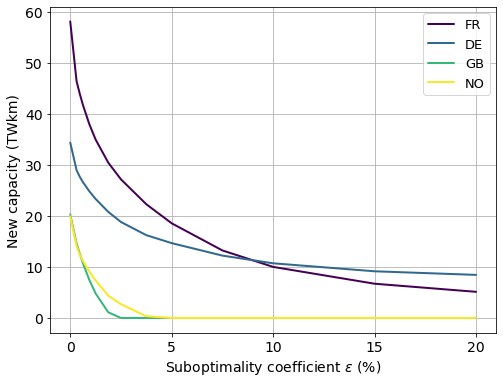

In [7]:
# Check total capacity per country that is minimized
new_capacities_df = pd.DataFrame(index=buses_ids, columns=[optimal_case] + epsilons, dtype=float)
for eps in [optimal_case] + epsilons:
    for bus in buses_ids:
        net = get_net(f'{eps}_{bus}' if eps != optimal_case else eps)
        adjacent_links = net.links[(net.links.bus0 == bus) | (net.links.bus1 == bus)].index
        new_capacities_df.loc[bus, eps] = ((net.links.loc[adjacent_links].p_nom_opt 
                                              - net.links.loc[adjacent_links].p_nom) 
                                           * net.links.loc[adjacent_links].length).sum()/1000
        
# print(f"New capacity when minimizing country capacity\n{new_capacities_df.round(2)}\n")
# print(f"New capacity when minimizing whole capacity\n{whole_new_capacities_df.round(2)}")
params = {'colormap': 'viridis',
          'lw': 2,
          'solid_capstyle': 'round',
          'figsize': (8, 6)}
# plt.figure(figsize=(12, 8))
plt.rc('font', size=14) 
print(new_capacities_df)
new_capacities_df.columns = [0.0] + [e*100 for e in epsilons]
new_capacities_df.T.plot(**params)
# plt.ylim([0, max(new_capacities_df["optimal"])*1.1])
plt.xlabel("Suboptimality coefficient " + r'$\epsilon$' + " (%)")
plt.ylabel("New capacity (TWkm)")
plt.grid()
plt.legend(buses_ids, prop={'size': 13})# bbox_to_anchor=(1,1), loc="upper left")
ticks = [0, 5, 10, 15, 20]
plt.xticks(ticks=ticks)
print(len(optimal_net.global_constraints))
plt.savefig("country_cap.eps", format='eps', bbox_inches='tight')
plt.savefig("country_cap.pdf", format='pdf', bbox_inches='tight')

    optimal  0.0125   0.025    0.05     0.1     0.2
FR   333.19  330.51  325.54  317.11  305.28  296.87
DE   333.19  311.55  306.63  305.35  306.07  308.21
BE   333.19  321.29  321.01  322.67  322.85  342.06
CH   333.19  316.66  312.07  308.46  314.15  333.68
GB   333.19  330.05  331.75  329.91  334.22  349.37


<Figure size 864x576 with 0 Axes>

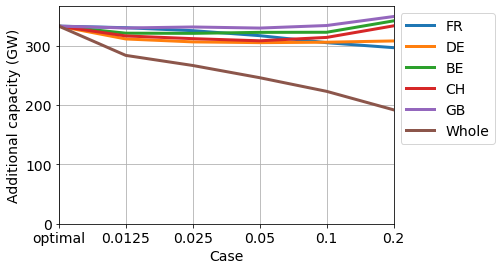

In [7]:
# Check total capacity, per country that is minimized
total_new_capacities_df = pd.DataFrame(index=buses_ids, columns=[optimal_case] + epsilons, dtype=float)
for eps in [optimal_case] + epsilons:
    for bus in buses_ids:
        net = get_net(f'{eps}_{bus}' if eps != optimal_case else eps)
        total_new_capacities_df.loc[bus, eps] = (net.links.p_nom_opt - net.links.p_nom).sum()
        
whole_total_new_capacities_ds = pd.Series(index=[optimal_case] + epsilons, dtype=float)
for eps in [optimal_case] + epsilons:
    net = get_net(eps)
    whole_total_new_capacities_ds[eps] = (net.links.p_nom_opt - net.links.p_nom).sum()

print(total_new_capacities_df.round(2))
plt.figure(figsize=(12, 8))
ax = total_new_capacities_df.T.plot(lw=3)
whole_total_new_capacities_ds.T.plot(ax=ax, lw=3)
plt.ylim([0, max(total_new_capacities_df["optimal"])*1.1])
plt.xlabel("Case")
plt.ylabel("Additional capacity (GW)")
plt.xlim([0, len(epsilons)])
plt.grid()
plt.legend(buses_ids+['Whole'], bbox_to_anchor=(1,1), loc="upper left")

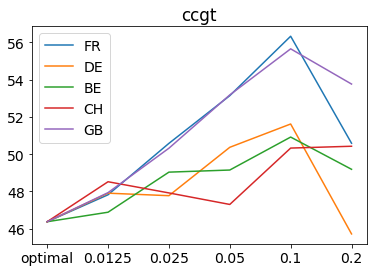

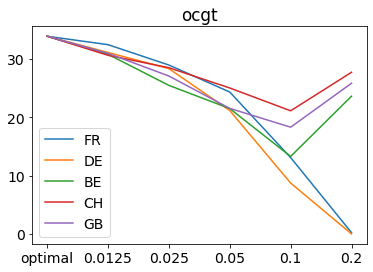

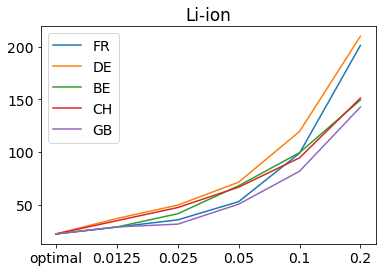

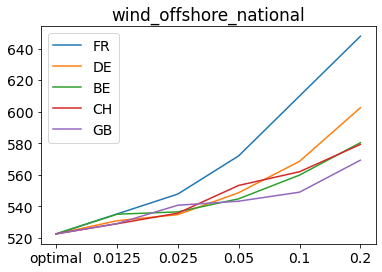

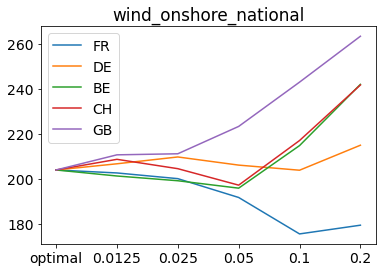

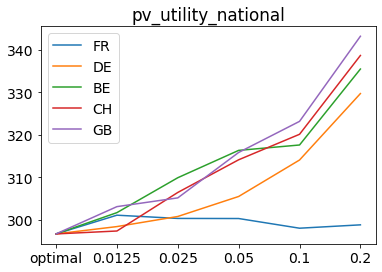

In [8]:
# What is replacing transmission capacity?
techs = ["ccgt", "ocgt", "Li-ion", "wind_offshore_national", "wind_onshore_national", "pv_utility_national"]
for tech in techs:
    total_new_capacities_df = pd.DataFrame(index=buses_ids, columns=[optimal_case] + epsilons, dtype=float)
    for eps in [optimal_case] + epsilons:
        for bus in buses_ids:
            net = get_net(f'{eps}_{bus}' if eps != optimal_case else eps)
            if tech == 'Li-ion':
                sus = net.storage_units[net.storage_units.type == tech]
                total_new_capacities_df.loc[bus, eps] = (sus.p_nom_opt - sus.p_nom).sum()
            else:
                gens = net.generators[net.generators.type == tech]
                total_new_capacities_df.loc[bus, eps] = (gens.p_nom_opt - gens.p_nom).sum()
    total_new_capacities_df.T.plot()
    plt.title(tech)

In [9]:
for eps in epsilons:
    eps_cases = [base_case] + [case.split("_")[1] for case in cases if case.startswith(str(eps))]    
    bus_links_capacities_new_df = pd.DataFrame(columns=eps_cases, index=buses_ids, dtype=float)
    bus_links_capacities_limits_df = pd.DataFrame(index=buses_ids, columns=['init', 'max'], dtype=float)
    total_transmission_capacities_df = pd.DataFrame(index=eps_cases, columns=['new', 'total'], dtype=float)
    
    
    for case in eps_cases:
        total_transmission_capacities_df.loc[case, 'new'] = (net.links.p_nom_opt - net.links.p_nom).sum()
        total_transmission_capacities_df.loc[case, 'total'] = net.links.p_nom_opt.sum()
        for bus in buses_ids:
            adjacent_links = net.links[(net.links.bus0 == bus) | (net.links.bus1 == bus)].index
            bus_links_capacities_new_df.loc[bus, case] = (net.links.loc[adjacent_links].p_nom_opt 
                                                          - net.links.loc[adjacent_links].p_nom).sum()
            if case == base_case:
                bus_links_capacities_limits_df.loc[bus, 'init'] = net.links.loc[adjacent_links].p_nom.sum()
                bus_links_capacities_limits_df.loc[bus, 'max'] = \
                (net.links.loc[adjacent_links].p_nom_max - net.links.loc[adjacent_links].p_nom).sum()

    if eps == epsilons[0]:
        print("Initial and Max addable capacity")
        print(bus_links_capacities_limits_df)
    print('Added capacity')
    print(eps)
    print(bus_links_capacities_new_df.round(2).T)
    print("Total capacity")
    print(total_transmission_capacities_df)

NameError: name 'base_case' is not defined